In [1]:
import json
import os
import re
from types import SimpleNamespace

import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

from model.vi_encoder import VIEncoder
from utils.solvers import FISTA
from utils.data_loader import load_whitened_images


In [32]:
# Coadapt baseline
file_list = [
    "comp256_v3/laplacian_avg_thresh_100samp",
    "comp256_v3/laplacian_max_thresh_100samp",
]

file_labels = [
    "Avg Sampling",
    "Max Sampling",
]

base_lambda = 20.0

In [33]:
#with open(base_run + "config.json") as json_data:
with open(file_list[0] + '_v1/config.json') as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
train_args.val_samples = 20000

gt_dictionary = np.load(file_list[0] + '_v1/train_savefile.npz')['phi'][-1]

train_patches, val_patches = load_whitened_images(train_args, gt_dictionary)

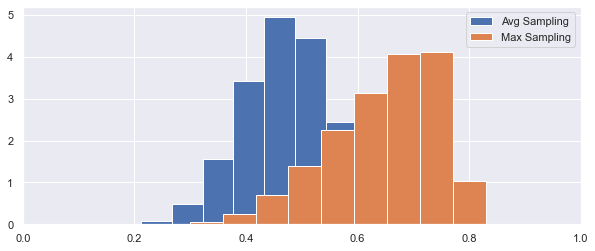

In [34]:
epoch_list = [300]
num_trials = 3
num_inference = 20

for epoch in epoch_list:
    jaccard_hist = {}
    plt.figure(figsize=(10,4))

    for idx, train_run in enumerate(file_list):
        jaccard_hist[file_labels[idx]] = np.zeros((num_trials, len(val_patches)))

        for v in range(1, num_trials+1):
            with open(train_run + f'_v{v}/' + 'config.json') as json_data:
                config_data = json.load(json_data)
            train_args = SimpleNamespace(**config_data['train'])
            solver_args = SimpleNamespace(**config_data['solver'])

            np.random.seed(train_args.seed)
            torch.manual_seed(train_args.seed)
            
            encoder = VIEncoder(train_args.patch_size**2, train_args.dict_size, solver_args).to('cuda:0')
            encoder.load_state_dict(torch.load(train_run + f'_v{v}/' + f"encoderstate_epoch{epoch}.pt")['model_state'])
            encoder.ramp_hyperparams()

            if epoch == 0:
                phi = np.random.randn(train_args.patch_size ** 2, train_args.dict_size)
                phi /= np.sqrt(np.sum(phi ** 2, axis=0))
                phi = torch.tensor(phi, device='cuda:0').float()
            else:
                phi = torch.tensor(np.load(train_run + f'_v{v}/' + 'train_savefile.npz')['phi'][epoch - 1], device='cuda:0').float()
            
            phi_indices = torch.linalg.norm(phi, dim=0)
            #print(phi_indices)
            phi_indices = phi_indices[phi_indices > 1e-1].long().detach().cpu().numpy()

            for j in range(val_patches.shape[0] // train_args.batch_size):
                # Load next batch of validation patches
                patches = val_patches[j * train_args.batch_size:(j + 1) * train_args.batch_size].reshape(train_args.batch_size, -1).T
                patches_cu = torch.tensor(patches.T).float().to('cuda:0')

                support_idx = []
                for k in range(num_inference):
                    iwae_loss, recon_loss, kl_loss, b_cu, weight = encoder(patches_cu, phi.detach()) 

                    sample_idx = torch.distributions.categorical.Categorical(weight).sample().detach()
                    b_select = b_cu[torch.arange(len(b_cu)), sample_idx].detach().cpu().numpy()
                    b_support = np.abs(b_select) > 0
                    b_support = b_support[:, phi_indices]
                    support_idx.append(b_support)
                
                support_idx = np.stack(support_idx)
                for k in range(len(patches_cu)):
                    pairwise_jaccard = 0
                    for n in range(num_inference):
                        for m in range(1, num_inference):
                            pairwise_jaccard += sp.spatial.distance.jaccard(support_idx[n, k], support_idx[m, k])
                    jaccard_hist[file_labels[idx]][v-1, (j * train_args.batch_size) + k] = pairwise_jaccard / (num_inference * (num_inference - 1))

        bins = np.arange(0, 1, 0.1)
        plt.hist(jaccard_hist[file_labels[idx]].mean(axis=0).reshape(-1), label=file_labels[idx], density=True)
    plt.xlim([0, 1])
    plt.legend()
    stat, p = sp.stats.ks_2samp(jaccard_hist[file_labels[0]].mean(axis=0), jaccard_hist[file_labels[1]].mean(axis=0), alternative='greater')
    #plt.title(f"Avg Jaccard Index at Epoch {epoch}\n Kolmogorov-Smirnov Test: {p:.2E}")

    print()

Text(0, 0.5, 'Probability')

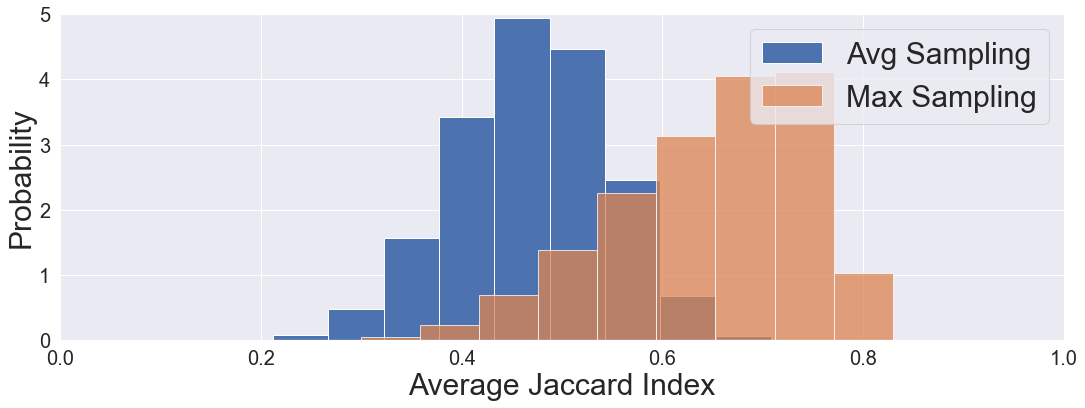

In [35]:
plt.figure(figsize=(18,6))
bins = np.arange(0, 1, 0.1)
plt.hist(jaccard_hist[file_labels[0]].mean(axis=0).reshape(-1), label=file_labels[0], density=True)
plt.hist(jaccard_hist[file_labels[1]].mean(axis=0).reshape(-1), label=file_labels[1], density=True, alpha=0.75)
plt.xlim([0, 1])
plt.ylim([0, 5])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=30, loc="upper right")
plt.xlabel("Average Jaccard Index", fontsize=30)
plt.ylabel("Probability", fontsize=30)
#plt.title(f"Avg Jaccard Index at Epoch {epoch}\n Kolmogorov-Smirnov Test: {p:.2E}")